In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from utils import unserialize
import os
from collections import defaultdict
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def get_lambda_file_names(file_names, lambda_list):
    """
    returns list of lists with file names for each lambda
    """
    file_names_lambda = []
    for l in lambda_list:
        l_names = [i for i in file_names if "pl_[{}]".format(l) in i]
        file_names_lambda.append(l_names)
    return file_names_lambda

def get_best_val(file_lists, dir_name, lambda_list, weight_decays, data_type):
    """
    for each list within the list of lists, returns the json with best val performance (for each lambda)
    """
    best_vals = []
    missing_wd_lambdas = []
    for i, l_file_list in enumerate(file_lists):
        wd_dict = defaultdict(int)
        unserialized_val_list = list(map(lambda f_name: unserialize(dir_name+f_name)[0], l_file_list))
        val_list_dcg = list(map(lambda x: x['validation']['dcg'], unserialized_val_list))
        if len(val_list_dcg) == 0:
            print("NO DATA FOR LAMBDA {} IN {}".format(lambda_list[i], dir_name))
        #check to see files for all weight_decays
        for wd in weight_decays:
            wd_list = [x for x in unserialized_val_list if x['weight_decay']==wd]
            wd_dict[wd] = [x for x in unserialized_val_list if x['weight_decay']==wd]
            if len(wd_list) == 0:
#                 print("-- NO FILE FOR WD {} FOR LAMBDA {} IN {}".format(wd, lambda_list[i], dir_name))
                baseline_type = "baseline" if "baseline" in dir_name else "ours"
                missing_wd_lambdas.append((data_type, baseline_type ,lambda_list[i], wd, 1.0))
        max_idx = np.argmax(np.asarray(val_list_dcg))
        best_vals.append(unserialized_val_list[max_idx])
    if missing_wd_lambdas:
#         dataset_name = "mslr" if "mslr" in dir_name else "german"
        print(dir_name, missing_wd_lambdas)
    return best_vals

def get_dcg_disp(best_vals, disp=None):
    """
    makes and gets the numpy array
    """
    assert disp is not None
    if disp in best_vals[0]["test"]["other_disparities"]:
        dcg_disp = [(b["test"]["dcg"], b["test"]["other_disparities"][disp][0]) for b in best_vals]
    else:
        dcg_disp = [(b["test"]["dcg"], b["test"]["avg_group_asym_disparity"]) for b in best_vals]
    return np.asarray(dcg_disp)

In [3]:
def get_plt_data(dir_name, lambda_list, disp, full=True):
    weight_decays = [0.0, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
    dir_file_names = os.listdir(dir_name)
    all_file_names = list(filter(lambda s: s.startswith("plt_data_pl_[") and s.endswith(".json"), dir_file_names))
    
    partial_file_names = list(filter(lambda s: "_partial_" in s, all_file_names))
    partial_lam_file_names = get_lambda_file_names(partial_file_names, lambda_list)
    parital_best_vals = get_best_val(partial_lam_file_names, dir_name, lambda_list, weight_decays, "partial")
    ps = get_dcg_disp(parital_best_vals, disp)
    pf = None
    if full:
        full_file_names = list(filter(lambda s: "_full_" in s, all_file_names))
        full_lam_file_names = get_lambda_file_names(full_file_names, lambda_list)
        full_best_vals = get_best_val(full_lam_file_names, dir_name, lambda_list, weight_decays, "full")
        pf = get_dcg_disp(full_best_vals, disp)
    
    return ps, pf

In [4]:
def plotDisparity(
    disp, 
    title,
    lambda_list,
    our_label_name='Our',
    baseline_label_name='Ashudeep Baseline',
    baseline_german='baseline_gp14_sp0_fix', 
    baseline_mslr='baseline_mslr_gp132', 
    german='gp14_sp0_fix', 
    mslr='mslr_gp132',
    save=False,
    full=True):
    
    p_baseline_german, f_baseline_german = get_plt_data('../output/{}/'.format(baseline_german),
                                                        lambda_list, disp, full=full)
    p_baseline_mslr, f_baseline_mslr = get_plt_data('../output/{}/'.format(baseline_mslr), 
                                                    lambda_list, disp, full=full)
    p_german, f_german = get_plt_data('../output/{}/'.format(german),
                                        lambda_list, disp, full=full)
    p_mslr, f_mslr = get_plt_data('../output/{}/'.format(mslr), lambda_list,
                                    disp, full=full)

    fig, ax = plt.subplots(4, 2, constrained_layout=True) if full else plt.subplots(2, 2, constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    fig_height = 20 if full else 10
    fig.set_figheight(fig_height)
    fig.set_figwidth(15)

    plt.setp(ax, xlabel='', xticks=np.arange(len(lambda_list)), xticklabels=lambda_list)
    
    our_label_name += " {}"
    baseline_label_name += " {}"

    ax[0, 0].plot(p_german[:,0], color='blue', label=our_label_name.format("DCG"))
    ax[0, 0].plot(p_baseline_german[:,0], color='red', label=baseline_label_name.format("DCG"))
    ax[0, 0].set_title("Partial German DCG")
    ax[0, 0].legend()

    ax[0, 1].plot(p_german[:,1], color='blue', label=our_label_name.format("Disparity"))
    ax[0, 1].plot(p_baseline_german[:,1], color='red', label=baseline_label_name.format("Disparity"))
    ax[0, 1].set_title("Partial German Disparity")
    ax[0, 1].legend()

    ax[1, 0].plot(p_mslr[:,0], color='blue', label=our_label_name.format("DCG"))
    ax[1, 0].plot(p_baseline_mslr[:,0], color='red', label=baseline_label_name.format("DCG"))
    ax[1, 0].set_title("Partial MSLR DCG")
    ax[1, 0].legend()

    ax[1, 1].plot(p_mslr[:,1], color='blue', label=our_label_name.format("Disparity"))
    ax[1, 1].plot(p_baseline_mslr[:,1], color='red', label=baseline_label_name.format("Disparity"))
    ax[1, 1].set_title("Partial MSLR Disparity")
    ax[1, 1].legend()

    if full:
        ax[2, 0].plot(f_mslr[:,0], color='blue', label=our_label_name.format("DCG"))
        ax[2, 0].plot(f_baseline_mslr[:,0], color='red', label=baseline_label_name.format("DCG"))
        ax[2, 0].set_title("Full MSLR DCG")
        ax[2, 0].legend()

        ax[2, 1].plot(f_mslr[:,1], color='blue', label=our_label_name.format("Disparity"))
        ax[2, 1].plot(f_baseline_mslr[:,1], color='red', label=baseline_label_name.format("Disparity"))
        ax[2, 1].set_title("Full MSLR Disparity")
        ax[2, 1].legend()

        ax[3, 0].plot(f_german[:,0], color='blue', label=our_label_name.format("DCG"))
        ax[3, 0].plot(f_baseline_german[:,0], color='red', label=baseline_label_name.format("DCG"))
        ax[3, 0].set_title("Full German DCG")
        ax[3, 0].legend()

        ax[3, 1].plot(f_german[:,1], color='blue', label=our_label_name.format("Disparity"))
        ax[3, 1].plot(f_baseline_german[:,1], color='red', label=baseline_label_name.format("Disparity"))
        ax[3, 1].set_title("Full German Disparity")
        ax[3, 1].legend()
    
    if save:
        plt.savefig('plots_pdf/' + title + '_disparity.pdf', bbox_inches='tight')

    fig.show()

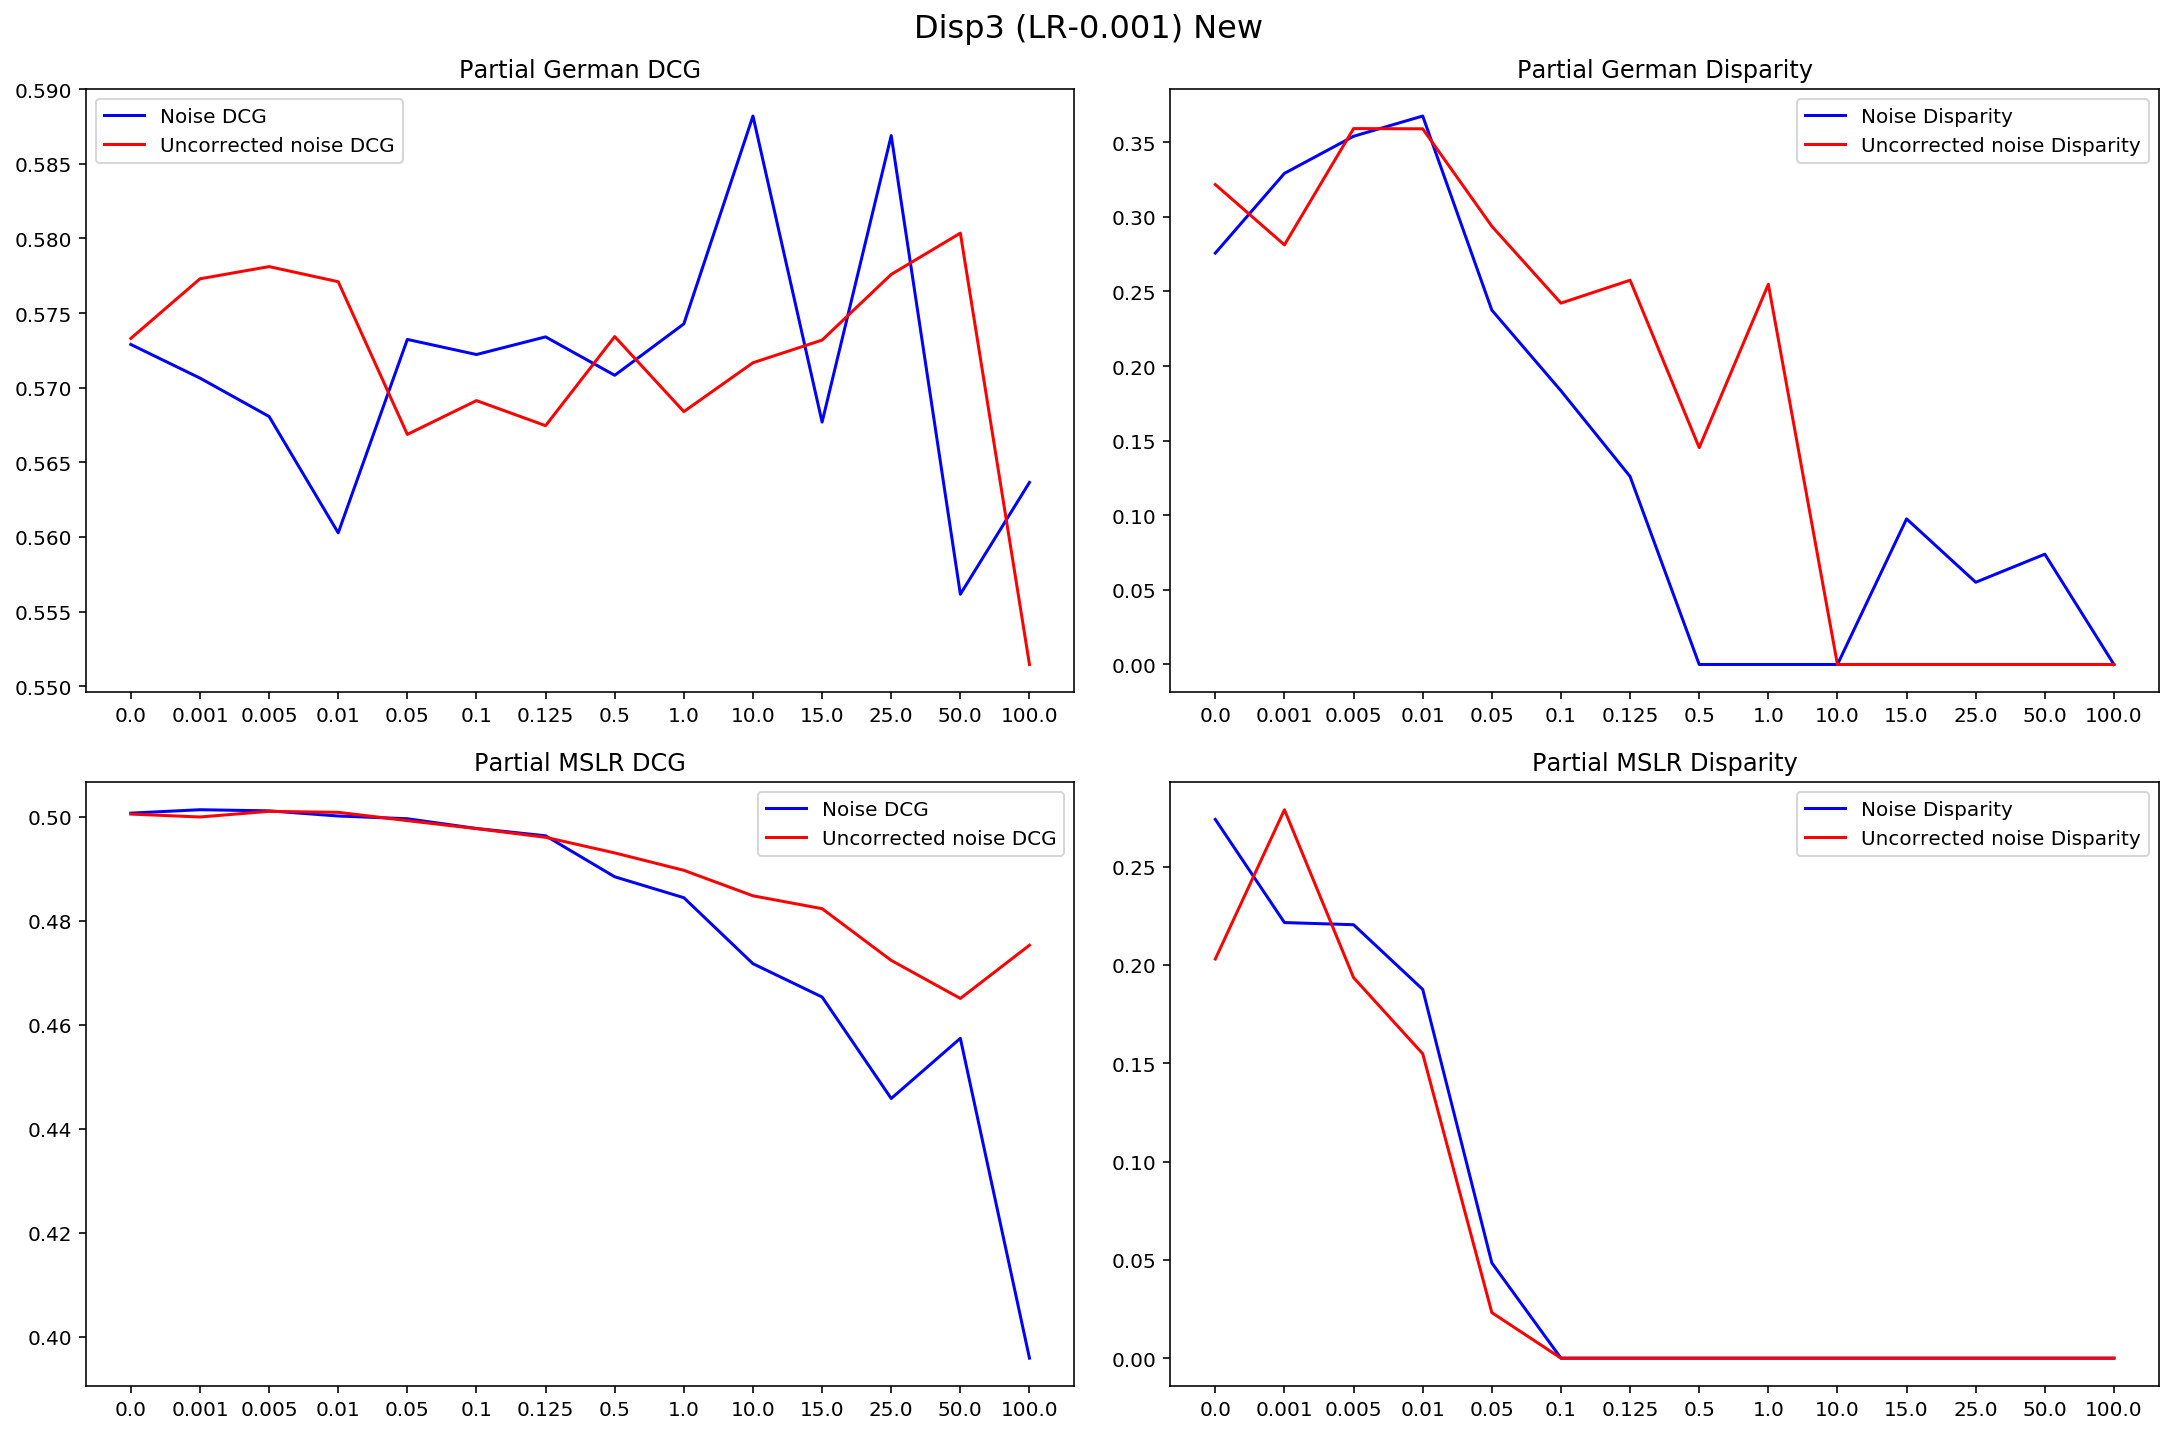

In [5]:
lambda_list = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.125, 0.5, 1.0, 10.0, 15.0, 25.0, 50.0, 100.0]

plotDisparity("disp3", "Disp3 (LR-0.001) New", lambda_list, our_label_name="Noise",
              baseline_label_name = "Uncorrected noise", baseline_german='gp14_sp0_try6_noise_en0', 
              german="gp14_sp0_try6_noise", mslr="mslr_gp132_try6_noise", 
              baseline_mslr="mslr_gp132_try6_noise_en0", full=False)

# baseline_mslr_gp132_try2 index 8, index 6

##### 